In [1]:
import json
import geojson
import shapely.wkt
from shapely import geometry
from xcube.core.geom import mask_dataset_by_geometry
import shapely.geometry
import IPython.display

In [2]:
f=open('countries.json')
data=json.load(f)
print(data['features'][0]['id'])
final=dict()
for i in range(0,len(data['features'])):
    #print(data['features'][i]['id'])
    final[data['features'][i]['id']]=data['features'][i]['geometry']['coordinates']

AFG


In [12]:
germany=geometry.Polygon(final['DEU'][0])

In [18]:
italy=geometry.Polygon(final['ITA'][2][0])

In [10]:
germany_area = shapely.wkt.loads(germany.wkt)
germany_gj = geojson.Feature(geometry=germany_area, properties={})

In [19]:
italy_area = shapely.wkt.loads(italy.wkt)
italy_gj = geojson.Feature(geometry=italy_area, properties={})

In [12]:
IPython.display.GeoJSON(germany_gj)

<IPython.display.GeoJSON object>

In [20]:
IPython.display.GeoJSON(italy_gj)

<IPython.display.GeoJSON object>

# Working with boxes (per la gioia di andre)

In [3]:
# Import required packages

from xcube_sh.config import CubeConfig
from xcube_sh.cube import open_cube
from xcube_sh.sentinelhub import SentinelHub
import xarray as xr

from sentinelhub import BBox, WmsRequest, DataSource, SHConfig
from functools import partial

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

In [4]:
# Set Sentinel Hub credentials

import os
sh_credentials = dict(client_id=os.environ['SH_CLIENT_ID'],
                      client_secret=os.environ['SH_CLIENT_SECRET']) # This is only provided when the Oauth credentials are created

# Sentinel-3 OLCI, Sentinel-3 SLSTR and Sentinel-5 layers are processed on different infrastructure, 
# which requires to used different end-point

sh_credentials.update(api_url='https://creodias.sentinel-hub.com') 

In [5]:

f=open('countries_box.json')
data=json.load(f)
print(data['features'][0]['id'])
final=dict()

ABW


# NO2

In [6]:
def caculateNO2(geometry, timerange):
    """
    parameters:
    geometry: BBox object to be passed. This contains the bounding box for the area of interest (AOI)
    timerange: list giving the start & end of the time range format: YYYY-mm-dd
    
    return:
    a dataframe with two columns: Mean NO2 and Timestamp
    NO2 mean values for the time span between given timerange 
    
    """
    cube_config = CubeConfig(dataset_name='S5PL2',
                         band_names=['NO2'],
                         tile_size=[512, 512],
                         geometry=geometry,
                         spatial_res=abs(bbox[2]-bbox[0])/512,
                         time_range= timerange,
                         time_period='3D') 
    cube = open_cube(cube_config, **sh_credentials)

    no2_values = list() 
    timestamp = list()

    for i in range(cube.time.shape[0]):
        no2_values.append(np.nanmean(cube.NO2.isel(time=i).values[0]))
        timestamp.append(cube.NO2.isel(time=i).time.values)
        
    assert len(no2_values) == len(timestamp)
    
    return pd.DataFrame({'DateTime': timestamp, 'Mean NO2': no2_values})

In [7]:
import pandas as pd

In [7]:
aoi = pd.DataFrame()
for ids in range(0,len(data['features'])):
    aoi=aoi.append([ [data['features'][ids]['id'],
                    data['features'][ids]['geometry']['sw']['lat'],
                    data['features'][ids]['geometry']['sw']['lon'],
                    data['features'][ids]['geometry']['ne']['lat'],
                    data['features'][ids]['geometry']['ne']['lon']]],ignore_index=True)

In [8]:
print(aoi.shape)
print(aoi.head(8))

shape = aoi.shape
nullCount = sum(aoi.isna().sum())
print(f"Shape of 2020 DF: {shape}, Count of Null values: {nullCount}".format(shape , nullCount ))

(246, 5)
     0          1          2          3          4
0  ABW  12.170300 -70.280984  12.810300 -69.640984
1  AFG  29.377200  60.517603  38.491068  74.889862
2  AGO -18.038945  11.460979  -4.388063  24.087886
3  AIA  18.061545 -63.639199  18.795119 -62.712545
4  ALA  59.454158  19.083210  60.876650  21.345656
5  ALB  39.644863  19.124609  42.661085  21.057433
6  AND  42.428824   1.413578  42.655936   1.786384
7  ANT  12.154454 -68.940593  12.154747 -68.940352
Shape of 2020 DF: (246, 5), Count of Null values: 0


In [41]:
aoi[0][110]

'ITA'

In [25]:
import time 

idx=109
start = time.time()
aoi_no2 = list()

# Check length of provided aoi list OR dataframe
len_aoi = len(aoi)

# Define how many AOIs you want to process. For the demo we will use only one 

aoi_dict = dict()
aoi_dict['Country_BBox'] = aoi[0][idx]
print("Processing: ", aoi_dict['Country_BBox'])
        
x1 = int(aoi[1][idx])  # degree 
y1 = int(aoi[2][idx])  # degree
x2 = int(aoi[3][idx])  # degree
y2 = int(aoi[4][idx])  # degree

bbox = x1, y1, x2, y2
timerange = ['2020-01-01', '2020-01-31']
aoi_dict['NO2_2020'] = caculateNO2(bbox, timerange)
shape = aoi_dict['NO2_2020'].shape
nullCount = sum(aoi_dict['NO2_2020'].isna().sum())
print(f"Shape of 2020 DF: {shape}, Count of Null values: {nullCount}".format(shape , nullCount ))    
    
timerange = ['2019-01-01', '2019-01-31']
aoi_dict['NO2_2019'] = caculateNO2(bbox, timerange)
shape = aoi_dict['NO2_2019'].shape
nullCount = sum(aoi_dict['NO2_2019'].isna().sum())
print(f"Shape of 2019 DF: {shape}, Count of Null values: {nullCount}".format(shape , nullCount ))

aoi_no2.append(aoi_dict)

end = time.time()
#print(len(aoi_no2))



Processing:  ISR


/opt/conda/envs/eurodatacube-0.24.5/lib/python3.8/site-packages/xcube_sh/config.py:99: UserWarning: the geometry parameter is no longer supported, use bbox instead
  warnings.warn('the geometry parameter is no longer supported, use bbox instead')
<ipython-input-6-1f8855b22f30>:25: RuntimeWarning: Mean of empty slice
  no2_values.append(np.nanmean(cube.NO2.isel(time=i).values[0]))


Shape of 2020 DF: (11, 2), Count of Null values: 2


/opt/conda/envs/eurodatacube-0.24.5/lib/python3.8/site-packages/xcube_sh/config.py:99: UserWarning: the geometry parameter is no longer supported, use bbox instead
  warnings.warn('the geometry parameter is no longer supported, use bbox instead')


Shape of 2019 DF: (11, 2), Count of Null values: 0


In [10]:
import pickle 
#print(len(aoi_no2))
with open('aoi_list_no2.pkl', 'wb') as f:
    pickle.dump(aoi_no2, f)

In [24]:
aoi[0][110]

'ITA'

In [11]:
import matplotlib.pyplot as plt

def plot_no2(idx):
    """
    parameters:
    idx: Input id for accessing NO2 data 
    
    return:
    None
    line plots for NO2 (2020 vs 2019) are generated
    """

    plt.plot(aoi_no2[idx]['NO2_2020']['DateTime'], aoi_no2[idx]['NO2_2020']['Mean NO2'],  label = 'NO2 levels (2020)')
    plt.plot(aoi_no2[idx]['NO2_2020']['DateTime'], aoi_no2[idx]['NO2_2019']['Mean NO2'], label = 'NO2 levels (2019)')
    plt.ylabel('NO2 Levels')
    plt.xlabel('Month')
    plt.title('NO2 levels for '+ aoi_no2[idx]['Country_BBox'])
    plt.legend()
    plt.savefig(aoi_no2[idx]['Country_BBox']+'.png')
    plt.show()

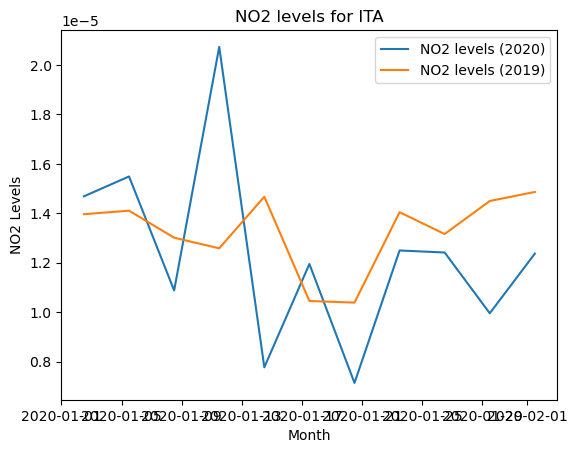

In [12]:
plot_no2(0)

# CO

In [28]:
def caculateCO(geometry, timerange):
    """
    parameters:
    geometry: BBox object to be passed. This contains the bounding box for the area of interest (AOI)
    timerange: list giving the start & end of the time range format: YYYY-mm-dd
    
    return:
    a dataframe with two columns: Mean NO2 and Timestamp
    NO2 mean values for the time span between given timerange 
    
    """
    cube_config = CubeConfig(dataset_name='S5PL2',
                         band_names=['CO'],
                         tile_size=[512, 512],
                         geometry=geometry,
                         spatial_res=abs(bbox[2]-bbox[0])/512,
                         time_range= timerange,
                         time_period='3D') 
    cube = open_cube(cube_config, **sh_credentials)

    co_values = list() 
    timestamp = list()

    for i in range(cube.time.shape[0]):
        co_values.append(np.nanmean(cube.CO.isel(time=i).values[0]))
        timestamp.append(cube.CO.isel(time=i).time.values)
        
    assert len(co_values) == len(timestamp)
    
    return pd.DataFrame({'DateTime': timestamp, 'Mean CO': co_values})

In [36]:
import time 

idx=110
start = time.time()
aoi_co = list()

# Check length of provided aoi list OR dataframe
len_aoi = len(aoi)

# Define how many AOIs you want to process. For the demo we will use only one 

aoi_dict = dict()
aoi_dict['Country_BBox'] = aoi[0][idx]
print("Processing: ", aoi_dict['Country_BBox'])
        
x1 = int(aoi[1][idx])  # degree 
y1 = int(aoi[2][idx])  # degree
x2 = int(aoi[3][idx])  # degree
y2 = int(aoi[4][idx])  # degree

bbox = x1, y1, x2, y2
timerange = ['2020-01-01', '2020-01-31']
aoi_dict['CO_2020'] = caculateCO(bbox, timerange)
shape = aoi_dict['CO_2020'].shape
nullCount = sum(aoi_dict['CO_2020'].isna().sum())
print(f"Shape of 2020 DF: {shape}, Count of Null values: {nullCount}".format(shape , nullCount ))    
    
timerange = ['2019-01-01', '2019-01-31']
aoi_dict['CO_2019'] = caculateCO(bbox, timerange)
shape = aoi_dict['CO_2019'].shape
nullCount = sum(aoi_dict['CO_2019'].isna().sum())
print(f"Shape of 2019 DF: {shape}, Count of Null values: {nullCount}".format(shape , nullCount ))

aoi_co.append(aoi_dict)

end = time.time()
#print(len(aoi_no2))



Processing:  ITA


/opt/conda/envs/eurodatacube-0.24.5/lib/python3.8/site-packages/xcube_sh/config.py:99: UserWarning: the geometry parameter is no longer supported, use bbox instead
  warnings.warn('the geometry parameter is no longer supported, use bbox instead')


Shape of 2020 DF: (11, 2), Count of Null values: 0


/opt/conda/envs/eurodatacube-0.24.5/lib/python3.8/site-packages/xcube_sh/config.py:99: UserWarning: the geometry parameter is no longer supported, use bbox instead
  warnings.warn('the geometry parameter is no longer supported, use bbox instead')


Shape of 2019 DF: (11, 2), Count of Null values: 0


In [37]:
import pickle 
#print(len(aoi_no2))
with open('aoi_list_co.pkl', 'wb') as f:
    pickle.dump(aoi_co, f)

In [38]:
import matplotlib.pyplot as plt

def plot_co(idx):
    """
    parameters:
    idx: Input id for accessing NO2 data 
    
    return:
    None
    line plots for NO2 (2020 vs 2019) are generated
    """

    plt.plot(aoi_co[idx]['CO_2020']['DateTime'], aoi_co[idx]['CO_2020']['Mean CO'],  label = 'CO levels (2020)')
    plt.plot(aoi_co[idx]['CO_2020']['DateTime'], aoi_co[idx]['CO_2019']['Mean CO'], label = 'CO levels (2019)')
    plt.ylabel('CO Levels')
    plt.xlabel('Month')
    plt.title('CO levels for '+ aoi_co[idx]['Country_BBox'])
    plt.legend()
    plt.savefig(aoi_co[idx]['Country_BBox']+'.png')
    plt.show()

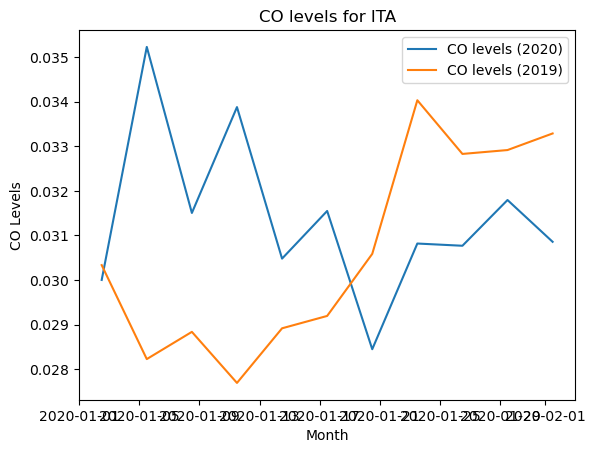

In [39]:
plot_co(0)

In [40]:
aoi_co

[{'Country_BBox': 'ITA',
  'CO_2020':               DateTime   Mean CO
  0  2020-01-02 12:00:00  0.030001
  1  2020-01-05 12:00:00  0.035227
  2  2020-01-08 12:00:00  0.031503
  3  2020-01-11 12:00:00  0.033878
  4  2020-01-14 12:00:00  0.030479
  5  2020-01-17 12:00:00  0.031548
  6  2020-01-20 12:00:00  0.028447
  7  2020-01-23 12:00:00  0.030818
  8  2020-01-26 12:00:00  0.030768
  9  2020-01-29 12:00:00  0.031793
  10 2020-02-01 12:00:00  0.030856,
  'CO_2019':               DateTime   Mean CO
  0  2019-01-02 12:00:00  0.030333
  1  2019-01-05 12:00:00  0.028226
  2  2019-01-08 12:00:00  0.028836
  3  2019-01-11 12:00:00  0.027691
  4  2019-01-14 12:00:00  0.028916
  5  2019-01-17 12:00:00  0.029193
  6  2019-01-20 12:00:00  0.030586
  7  2019-01-23 12:00:00  0.034031
  8  2019-01-26 12:00:00  0.032827
  9  2019-01-29 12:00:00  0.032914
  10 2019-02-01 12:00:00  0.033286}]